In [1]:
import os, sys, time
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numbers import Integral
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, truncnorm, foldnorm
import warnings
from time import perf_counter
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA


from farich_functions import *

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
datadir = 'data'

In [4]:
filepath = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_no.root')
# filepath_fixed = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_fixed.root')
filepath_fixed = os.path.join(datadir, 'fullsim_optical_10000_pi_500_1500_no.root')
filepath_monodir = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_monodir_no.root')
filepath_2pi = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_2pi_phi.root')
filepath_prototype = os.path.join(datadir, 'farichsim_10kevt.root')
filepath_new = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_spectre_test_3.root')

In [5]:
# file = uproot.open(filepath)
file = uproot.open(filepath_fixed)
# file = uproot.open(filepath_monodir)
# file_2pi = uproot.open(filepath_2pi)
# file_prototype = uproot.open(filepath_prototype)
# file_new = uproot.open(filepath_new)

In [6]:
plt.style.use('default')

In [7]:
# plot_cyl(file, transposed=True)

In [8]:
# np.concatenate(np.array(file['events;1']['FarichBarrelG4Hits.postStepPosition.x'].array())).shape

# Main (tmp obv)

In [9]:
def init_sipm_eff():
  pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
  t1 = []
  t2 = []
  for inedx, row in pdes_tmp.iterrows():
      t1.append(float(row['A'].split(';')[0].replace(',', '.')))
      t2.append(float(row['A'].split(';')[1].replace(',', '.')))
  PDE_wvs = np.linspace(200, 900, 128)
  PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
  sipm_eff = fix_PDE_plot(PDEs, PDE_wvs)
  return sipm_eff, PDE_wvs

In [10]:
sipm_eff, PDE_wvs = init_sipm_eff()

In [11]:
x_grid = np.arange(-3*norm_r * np.sin(np.pi / 27), 3*norm_r * np.sin(np.pi / 27), SIPM_CELL_SIZE)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

In [12]:
x = np.array(file['events;13']['FarichBarrelG4Hits.postStepPosition.x'].array())
y = np.array(file['events;13']['FarichBarrelG4Hits.postStepPosition.y'].array())
z = np.array(file['events;13']['FarichBarrelG4Hits.postStepPosition.z'].array())
wvs = 1239.841 / np.array(file['events;13']['FarichBarrelG4Hits.energy'].array()) * 1e-9

In [13]:
# x1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.x'].array())
# y1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.y'].array())
# z1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.z'].array())
# drift_chamber_coordinates = np.column_stack((x1, y1, z1))

In [14]:
# x2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.x'].array())
# y2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.y'].array())
# z2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.z'].array())
# tpc_coordinates = np.column_stack((x2, y2, z2))

In [15]:
x3 = np.array(file['events;13']['allGenParticles.core.p4.px'].array())
y3 = np.array(file['events;13']['allGenParticles.core.p4.py'].array())
z3 = np.array(file['events;13']['allGenParticles.core.p4.pz'].array())
true_direction_coordinates = np.column_stack((x3, y3, z3))

In [16]:
for i in range(len(wvs)):
    wvs[i] = lin_move_to_grid(wvs[i], grid[2])

In [17]:
coordinates = np.column_stack((x, y, z, wvs))

coordinates.shape

(10000, 4)

In [18]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)

In [19]:
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
# drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
# tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)
print(coordinates.shape)
# print(drift_chamber_coordinates.shape)
# print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(9977, 4)
(9977, 3)


In [20]:
sipm_sim(coordinates, sipm_eff)

In [21]:
# plot_cyl(file, coordinates, True)

In [22]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
# drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
# tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)

print(coordinates.shape)
# print(drift_chamber_coordinates.shape)
# print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(9835, 4)
(9835, 3)


In [23]:
main_angles = rotate_lines(true_direction_coordinates)

In [24]:
intersections = find_intersections(true_direction_coordinates)

In [25]:

# num = 7 # unturned events
# # plt.scatter(rotate_event(coordinates[0], main_angles[0])[:,0], rotate_event(coordinates[0], main_angles[0])[:,2])
# plt.scatter(coordinates[num][0], coordinates[num][2])
# plt.scatter(intersections[num][0], intersections[num][2])
# plt.show()

In [26]:
# plot_event(coordinates[num], drift_chamber_coordinates[num],tpc_coordinates[num] , transposed=True)

In [27]:
rotate_events(coordinates, main_angles)

In [28]:
# plot_cyl(file, coordinates)

In [29]:
move_events_to_grid(coordinates, grid)

In [30]:
# plot_cyl(file, coordinates, True)

In [31]:
# num = 2
# # plt.scatter(rotate_event(coordinates[0], main_angles[0])[:,0], rotate_event(coordinates[0], main_angles[0])[:,2])
# plt.scatter(coordinates[num][0], coordinates[num][2])
# plt.scatter(intersections[num][0], intersections[num][2])
# plt.show()

In [32]:
r_c = (coordinates[:,0] - intersections[:,0]) ** 2 + (coordinates[:,1] - intersections[:,1]) ** 2

In [33]:
repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])

In [34]:
edf = pd.DataFrame(coordinates, columns=['x_c', 'y_c', 'z_c', 'wv_c'])
edf['r_c'] = r_c

In [35]:
unraveled_data = {col: [] for col in edf.columns}
row_indices = []

# Iterate over the DataFrame and unravel the arrays
for i, row in edf.iterrows():
    max_length = max(len(row[col]) for col in edf.columns)
    for k in range(max_length):
        row_indices.append((i, k))
        for col in edf.columns:
            if k < len(row[col]):
                unraveled_data[col].append(row[col][k])
            else:
                unraveled_data[col].append(np.nan)  # Handle cases where arrays are of different lengths

# Create a new DataFrame from the unraveled data
unraveled_df = pd.DataFrame(unraveled_data)

# Create a MultiIndex for the rows
multi_index = pd.MultiIndex.from_tuples(row_indices, names=['entry', 'subentry'])
unraveled_df.index = multi_index


In [36]:
unraveled_df['r_c'] = np.sqrt(unraveled_df.r_c)

In [37]:
edf = unraveled_df

In [38]:
edf['x_i'] = np.repeat(intersections[:,0], repeat_nums, axis=0)
edf['z_i'] = np.repeat(intersections[:,2], repeat_nums, axis=0)

In [39]:
x = y = z = x3 = y3 = z3 = unraveled_data = row_indices = main_angles = intersections = wvs = coordinates = file =  0

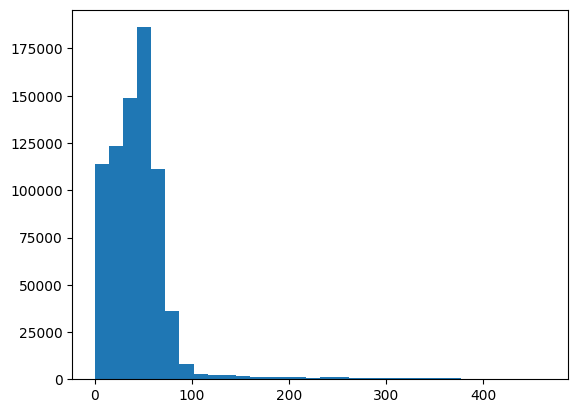

In [40]:
plt.hist(edf[edf.r_c<1000].r_c, bins='doane')
plt.show()

In [41]:
bdf = pd.DataFrame()
edf['t_c'] = np.zeros(edf.shape[0])
edf.drop('y_c', axis=1, inplace=True)
edf.rename(columns={'z_c': 'y_c', 'z_i': 'y_i'}, inplace=True)
edf['z_c'] = np.zeros(edf.shape[0]) + 2000
edf['true_p'] = np.repeat(np.linalg.norm(true_direction_coordinates.astype('float'), axis=1)*1000, repeat_nums, axis=0)
edf['beta'] = edf.true_p / np.sqrt(139.57 ** 2 + edf.true_p ** 2)
edf['nx_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,0], repeat_nums, axis=0)
edf['ny_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,2], repeat_nums, axis=0)
edf['nz_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,1], repeat_nums, axis=0)

C:\Users\BRINE\AppData\Local\Temp\ipykernel_22172\1986587013.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edf['true_p'] = np.repeat(np.linalg.norm(true_direction_coordinates.astype('float'), axis=1)*1000, repeat_nums, axis=0)
C:\Users\BRINE\AppData\Local\Temp\ipykernel_22172\1986587013.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edf['nx_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
C:\Users\BRINE\AppData\Local\Temp\ipykernel_22172\1986587013.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a 

In [42]:
true_direction_coordinates = repeat_nums = 0

In [43]:
edf.shape[0]

752103

In [44]:
idf = pd.DataFrame()
# idf['W'] = [35.]
idf['W'] = [40.]

idf['zdis'] = [800.]
idf['distance'] = [200.]
# idf['n_mean'] = [1.0454]

idf['n_mean'] = [1.0502]

idf['pixel_size'] = [3.16]

In [45]:
idf

,W,zdis,distance,n_mean,pixel_size
0,40.0,800.0,200.0,1.0502,3.16


In [46]:
edf = applySpaceCut(edf)

In [47]:
planeRecalculation(edf, idf)

Z:\Prog\FARICH\farich_functions.py:359: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha = (float(dist)) / N[:, 2]
Z:\Prog\FARICH\farich_functions.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['t_c'] = edf['t_c'] + np.sign(R_new[:, 2] - R[:, 2]) * t_dif
Z:\Prog\FARICH\farich_functions.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['recalculated_x'] = R_new[:, 0]
Z:\Prog\FARICH\farich_

In [48]:
edf['x_p'] = np.zeros(edf.shape[0])
edf['y_p'] = np.zeros(edf.shape[0])
edf['z_p'] = np.zeros(edf.shape[0])


C:\Users\BRINE\AppData\Local\Temp\ipykernel_22172\210028248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['x_p'] = np.zeros(edf.shape[0])
C:\Users\BRINE\AppData\Local\Temp\ipykernel_22172\210028248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['y_p'] = np.zeros(edf.shape[0])
C:\Users\BRINE\AppData\Local\Temp\ipykernel_22172\210028248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [49]:
planeRotation(edf)

Z:\Prog\FARICH\farich_functions.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['rotated_x'] = rotated_R[:,0]
Z:\Prog\FARICH\farich_functions.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['rotated_y'] = rotated_R[:,1]
Z:\Prog\FARICH\farich_functions.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [50]:
edf = applySecondSpaceCut(edf)

In [51]:
bdf = pd.DataFrame()
edf_to_bdf(edf.r_c.groupby(level=0).transform('mean'), bdf)
bdf.rename(columns={'r_c': 'r_c_mean'}, inplace=True)
edf_to_bdf(edf.r_c.groupby(level=0).transform('std'), bdf)
bdf.rename(columns={'r_c': 'r_c_std'}, inplace=True)
edf_to_bdf(edf.r_c.groupby(level=0).transform(lambda x: x.max() - x.min()), bdf)
bdf.rename(columns={'r_c': 'r_c_width'}, inplace=True)
edf_to_bdf(edf.true_p, bdf)
bdf.rename(columns={'true_p': 'momentum'}, inplace=True)

In [52]:
edf

x_c     y_c        wv_c        r_c        x_i  \
entry subentry                                                         
0     0         123.040131  135.52  530.708661  51.800917  71.239214   
      1          69.280131   44.80  359.842520   1.959083  71.239214   
      2          12.160131  125.44  409.448819  59.079083  71.239214   
      3         112.960131  152.32  718.110236  41.720917  71.239214   
      4         119.680131  148.96  547.244094  48.440917  71.239214   
...                    ...     ...         ...        ...        ...   
9834  67        -31.519869 -244.16  618.897638  46.007457 -77.527326   
      68        -95.359869 -220.64  453.543307  17.832543 -77.527326   
      69       -132.319869 -281.12  310.236220  54.792543 -77.527326   
      70       -115.519869 -314.72  470.078740  37.992543 -77.527326   
      71        -98.719869 -220.64  381.889764  21.192543 -77.527326   

                       y_i       t_c     z_c       true_p      beta  ...  z_p  \
entry subentry                                                       ...        
0     0         102.379707 -0.023488  2000.0  1408.464406  0.995126  ...  0.0   
      1         102.379707  0.020196  2000.0  1408.464406  0.995126  ...  0.0   
      2         102.379707  0.006167  2000.0  1408.464406  0.995126  ...  0.0   
      3         102.379707 -0.026796  2000.0  1408.464406  0.995126  ...  0.0   
      4         102.379707 -0.027242  2000.0  1408.464406  0.995126  ...  0.0   
...                    ...       ...     ...          ...       ...  ...  ...   
9834  67       -264.051181  0.029317  2000.0  1394.755125  0.995031  ...  0.0   
      68       -264.051181  0.033536  2000.0  1394.755125  0.995031  ...  0.0   
      69       -264.051181 -0.028751  2000.0  1394.755125  0.995031  ...  0.0   
      70       -264.051181 -0.053340  2000.0  1394.755125  0.995031  ...  0.0   
      71       -264.051181  0.032664  2000.0  1394.755125  0.995031  ...  0.0   

                 rotated_x   rotated_y    rotated_z  rotated_x_i  rotated_y_i  \
entry subentry                                                                  
0     0         -19.026015  -68.401037  2000.059575   -70.691475  -101.592538   
      1         -72.809555 -159.681578  2000.059575   -70.691475  -101.592538   
      2        -129.908448  -78.561477  2000.059575   -70.691475  -101.592538   
      3         -29.056611  -51.707900  2000.059575   -70.691475  -101.592538   
      4         -22.384412  -55.045632  2000.059575   -70.691475  -101.592538   
...                    ...         ...          ...          ...          ...   
9834  67        121.328794  275.410648  2001.332499    74.748496   254.586731   
      68         57.027686  299.265484  2001.332499    74.748496   254.586731   
      69         20.129547  236.874613  2001.332499    74.748496   254.586731   
      70         36.850950  203.179241  2001.332499    74.748496   254.586731   
      71         53.636903  299.232456  2001.332499    74.748496   254.586731   

                rotated_z_i  rotated_nx_p  rotated_ny_p  rotated_nz_p  
entry subentry                                                         
0     0         2000.059575     -0.035277     -0.050698      0.998091  
      1         2000.059575     -0.035277     -0.050698      0.998091  
      2         2000.059575     -0.035277     -0.050698      0.998091  
      3         2000.059575     -0.035277     -0.050698      0.998091  
      4         2000.059575     -0.035277     -0.050698      0.998091  
...                     ...           ...           ...           ...  
9834  67        2001.332499      0.037025      0.126105      0.991326  
      68        2001.332499      0.037025      0.126105      0.991326  
      69        2001.332499      0.037025      0.126105      0.991326  
      70        2001.332499      0.037025      0.126105      0.991326  
      71        2001.332499      0.037025      0.126105      0.991326  

[731845 rows x 28 columns]

In [53]:
bdf.isna().sum()

r_c_mean     0
r_c_std      2
r_c_width    0
momentum     0
dtype: int64

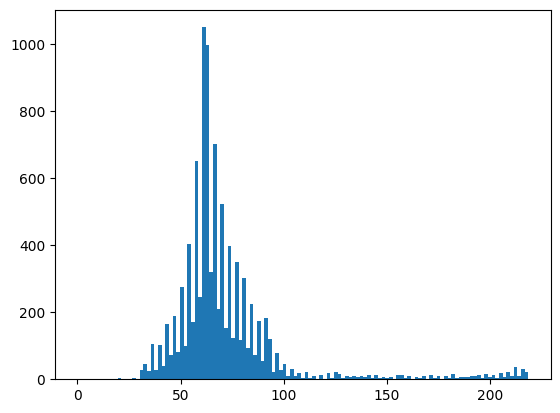

In [54]:
plt.hist(bdf[bdf.r_c_width < 1000].r_c_width, bins='auto')
plt.show()

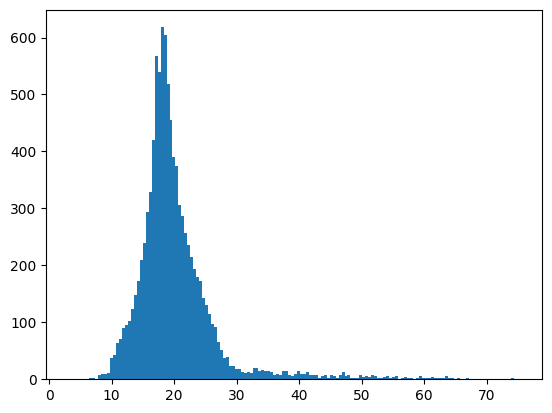

In [55]:
plt.hist(bdf[bdf.r_c_std < 1000].r_c_std, bins='auto')
plt.show()

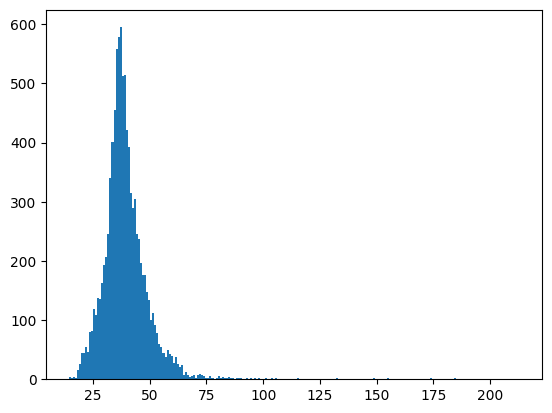

In [56]:
plt.hist(bdf[bdf.r_c_mean < 1000].r_c_mean, bins='auto')
plt.show()

In [57]:
# np.tan(1 / (edf.beta.iloc[0] * idf.n_mean)) 

In [58]:
# idf.W * np.tan(1/(idf.n_mean * edf.beta.iloc[0]))

In [59]:
# num = 7
# event = edf.loc[num]
# plt.scatter(event.rotated_x, event.rotated_y)
# plt.scatter(event.rotated_x_i, event.rotated_y_i)
# plt.show()

In [60]:
primaryDirectionRecalculation(edf)

In [61]:
edf['rotated_r_c'] = np.sqrt((edf['rotated_x_i'] - edf['rotated_x']) ** 2 + (edf['rotated_y_i'] - edf['rotated_y']) ** 2)
edf['signal'] = np.ones(edf.shape[0])

In [62]:
recoAngles(edf, idf)

Z:\Prog\FARICH\farich_functions.py:478: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dist = float(idf['distance'])
Z:\Prog\FARICH\farich_functions.py:481: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = float(idf['W'])
Z:\Prog\FARICH\farich_functions.py:484: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rad_pos = float(idf['zdis'])


In [63]:
recoAngles(edf, idf, rotation_mode=True)

Z:\Prog\FARICH\farich_functions.py:478: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dist = float(idf['distance'])
Z:\Prog\FARICH\farich_functions.py:481: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = float(idf['W'])
Z:\Prog\FARICH\farich_functions.py:484: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rad_pos = float(idf['zdis'])
Z:\Prog\FARICH\farich_functions.py:499: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  n_mean = float(idf['n_mean'])


In [64]:
# event = edf.loc[23]
# plt.subplot()
# plt.scatter(event.phi_c, event.theta_c)
# plt.show()
# plt.subplot()
# plt.gca().invert_yaxis()
# plt.scatter(event.rotated_x, event.rotated_y)
# plt.show()

In [65]:
def calibration(edf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', t_window_width=2,
                        r_width_factor=2, t_width_factor=8, full_width_t_hist = False, weighed=True, deg_lim=False, param_fit=False):
  def gaussian(x, mean, sigma):
    return norm.pdf(x, loc=mean, scale=sigma)
  # to_return_unbinned = [[], [], [], []]
  bdf['cos_theta_p'] = np.cos(bdf['theta_p'])
  
  theta_p_max = max(bdf.theta_p)
  theta_p_min = min(bdf.theta_p)
  
  num_of_theta_intervals = 11
  theta_intervals = np.linspace(theta_p_min, theta_p_max, num=num_of_theta_intervals)
  theta_dif = (theta_intervals[1:] + theta_intervals[:-1]) / 2
  to_return_unbinned = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), num_of_theta_intervals - 1, 3), 0.)

  errs_tmp = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), num_of_theta_intervals - 1, 3), 0.)
  fit_params = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), 3, 3), 0.)

  weight = 'weighed' if weighed else 'unweighed'
  momentum_min = min(bdf.momentum)
  momentum_max = max(bdf.momentum)
  num_of_momentum_intervals = 10 # was 20
  momentum_delim = (max(bdf.momentum) - min(bdf.momentum)) / num_of_momentum_intervals
  momentum_intervals = np.linspace(min(bdf.momentum), max(bdf.momentum), num=num_of_momentum_intervals + 1)
  dir_to_save = f'{weight}_rw={step}_tw={t_window_width}_rs={r_width_factor}_ts={t_width_factor}'
  if not os.path.exists(os.path.join('calibrations_barrel', dir_to_save)):
    os.mkdir(os.path.join('calibrations_barrel', dir_to_save))
  for r_sigms in range(*avg_sigmas):
    fig, axs = plt.subplots(num_of_theta_intervals - 1, np.ptp(avg_t_sigmas), figsize=(16 * np.ptp(avg_t_sigmas), 90))
    for t_sigms in range(*avg_t_sigmas):
      chosen_column = f'unfixed_calculated_r_2d_{r_sigms}_rsigms_{t_sigms}_tsigms'

      meas_r_min = min(bdf[chosen_column])
      meas_r_max = max(bdf[chosen_column])
      num_of_meas_r_intervals = num_of_momentum_intervals
      meas_r_delim = (meas_r_max - meas_r_min) / num_of_meas_r_intervals
      meas_r_intervals = np.linspace(meas_r_min, meas_r_max, num=num_of_meas_r_intervals + 1)


      # fig2, axs2 = plt.subplots(10* num_of_theta_intervals - 10, 10, figsize=(16, 90))

      for theta_interval_index in range(num_of_theta_intervals - 1):
        xerrs = []
        yerrs = []
        gauss_momentum = []
        gauss_r = []
        t_bdf = bdf.copy()
        t_bdf = t_bdf[np.isfinite(t_bdf[chosen_column])]
        t_bdf = t_bdf[t_bdf.signal_counts >= 15]
        t_bdf = t_bdf[t_bdf.theta_p <= theta_intervals[theta_interval_index + 1]]
        t_bdf = t_bdf[t_bdf.theta_p >= theta_intervals[theta_interval_index]]
        if t_sigms - avg_t_sigmas[0] != 0:
          for_colorbar = axs[theta_interval_index, t_sigms - avg_t_sigmas[0]].hist2d(t_bdf[chosen_column], t_bdf.momentum, bins=70, range=((0, 80), (momentum_min,momentum_max)))
          fig.colorbar(for_colorbar[3], ax=axs[theta_interval_index, t_sigms - avg_t_sigmas[0]])
        else:
          for_colorbar = axs[theta_interval_index].hist2d(t_bdf[chosen_column], t_bdf.momentum, bins=70, range=((0, 80), (momentum_min,momentum_max)))
          fig.colorbar(for_colorbar[3], ax=axs[theta_interval_index])
        # t_bdf = t_bdf[t_bdf[chosen_column] <= 65]
        # t_bdf = t_bdf[t_bdf[chosen_column] >= 25]

        pol_param, cov = curve_fit(momentum_pol, t_bdf[chosen_column], t_bdf.momentum, maxfev=50000)
        to_return_unbinned[r_sigms - avg_sigmas[0]][t_sigms - avg_t_sigmas[0]][theta_interval_index] = pol_param
        pol_param_errs = np.sqrt(np.diag(cov))
        errs_tmp[r_sigms - avg_sigmas[0]][t_sigms - avg_t_sigmas[0]][theta_interval_index] = pol_param_errs
        rs = np.linspace(10, 80, num=50)
        chi2 = np.sum((t_bdf.momentum - pol(t_bdf[chosen_column], *pol_param)) ** 2)

        if t_sigms - avg_t_sigmas[0] != 0:
          # axs[theta_interval_index, t_sigms - avg_t_sigmas[0]].plot(rs, pol(rs, *pol_param), label=r'$\chi^2$ = '+ str(chi2), c='r')
          axs[theta_interval_index, t_sigms - avg_t_sigmas[0]].set_xlim((0, 90))
          # axs[theta_interval_index, t_sigms - avg_t_sigmas[0]].set_ylim((0.955, momentum_max))
          axs[theta_interval_index, t_sigms - avg_t_sigmas[0]].set_ylim((momentum_min, momentum_max))
          axs[theta_interval_index, t_sigms - avg_t_sigmas[0]].set_xlabel(r'$R_{reco}$, mm')
          axs[theta_interval_index, t_sigms - avg_t_sigmas[0]].set_ylabel(r'$momentum_{true}$')
        else:
          axs[theta_interval_index].plot(rs, momentum_pol(rs, *pol_param), label=r'$\chi^2$ = '+ str(chi2), c='r')
          axs[theta_interval_index].set_xlim((0, 90))
          # axs[theta_interval_index].set_ylim((0.955, momentum_max))
          axs[theta_interval_index].set_ylim((momentum_min, momentum_max))
          axs[theta_interval_index].set_xlabel(r'$R_{reco}$, mm')
          axs[theta_interval_index].set_ylabel(r'$momentum_{true}$')
      if param_fit:
        t_bdf = bdf.copy()
        t_bdf = t_bdf[np.isfinite(t_bdf[chosen_column])]
        t_bdf = t_bdf[t_bdf.signal_counts >= 5]
        X = (np.array(t_bdf[chosen_column]), np.array(t_bdf.theta_p))
        fit, errs = curve_fit(momentum_d3pol2, X, t_bdf.momentum, p0=(1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751))
        errs = np.sqrt(np.diag(errs))
        for param in range(3):
          fit_params[r_sigms - avg_sigmas[0]][t_sigms - avg_t_sigmas[0]][param] = fit[param * 3: param * 3 + 3]
        # print(fit)
        # print(errs)
        chi2 = np.sum((t_bdf.momentum - momentum_d3pol2(X, *fit)) ** 2)
        # print(chi2)
      # if param_fit:
      #   for param in range(3):
      #     fit, _ = curve_fit(pol2, theta_dif, to_return_unbinned[r_sigms - avg_sigmas[0]][t_sigms - avg_t_sigmas[0]][:, param], sigma=errs_tmp[r_sigms - avg_sigmas[0]][t_sigms - avg_t_sigmas[0]][:, param])
      #     fit_params[r_sigms - avg_sigmas[0]][t_sigms - avg_t_sigmas[0]][param] = fit
    filename = f'rsigm={r_sigms}_t_sigms={avg_t_sigmas[0]}-{avg_t_sigmas[-1] - 1}'
    if deg_lim:
      filename += '_10deg'
    if dir_to_save != '':
      fig.savefig(os.path.join('calibrations_barrel', dir_to_save, f'{filename}'))
      plt.close(fig)


  if param_fit:
    return fit_params
  return to_return_unbinned
# cal_arr = np.array(calibration(edf, bdf, avg_sigmas=(1, 5), avg_t_sigmas=(1, 5))) # add r and t calibr - done

C:\Users\BRINE\AppData\Local\Temp\ipykernel_22172\1343910433.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  def calibration(edf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', t_window_width=2,


In [66]:
def rSlidingWindow(edf: pd.DataFrame, idf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', cal_arr=False, t_window_width=2,
                        r_width_factor=2, t_width_factor=8, full_width_t_hist = True, num_of_groups=5, weighed=True, deg_lim=False, param_fit=False):
  rSlidingWindowIntro(edf, idf, bdf, avg_sigmas, avg_t_sigmas, step=step, method=method, cal_arr=cal_arr, t_window_width=t_window_width,
                      r_width_factor=r_width_factor, t_width_factor=t_width_factor, num_of_groups=num_of_groups)
  calculateSignalCounts(edf, bdf)
  rSlidingWindowLoop1(edf, idf, bdf, avg_sigmas, avg_t_sigmas, step=step, method=method, cal_arr=cal_arr, t_window_width=t_window_width,
                      r_width_factor=r_width_factor, t_width_factor=t_width_factor, full_width_t_hist=full_width_t_hist, weighed=weighed)
  if cal_arr is False:
    cal_arr = np.array(calibration(edf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, step=step, t_window_width=t_window_width,
                                   r_width_factor=r_width_factor, t_width_factor=t_width_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit)) # add r and t calibr - done
  rSlidingWindowLoop2(edf, idf, bdf, avg_sigmas, avg_t_sigmas, step=step, method=method, cal_arr=cal_arr, t_window_width=t_window_width,
                      r_width_factor=r_width_factor, t_width_factor=t_width_factor, param_fit=param_fit)
  return cal_arr

C:\Users\BRINE\AppData\Local\Temp\ipykernel_22172\4254145861.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  def rSlidingWindow(edf: pd.DataFrame, idf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', cal_arr=False, t_window_width=2,


In [67]:
avg_sigmas = (4, 5)
avg_t_sigmas = (4, 5)
num_of_groups = 10
r_width = float(idf.pixel_size) * 2
t_width = 0.25
t_step = 0.25
r_factor = 2 # not to change
t_factor = int(t_width / t_step)
weighed = True
deg_lim = False
param_fit = False # WORKS
# sample_size = 12

C:\Users\BRINE\AppData\Local\Temp\ipykernel_22172\4259162084.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r_width = float(idf.pixel_size) * 2


In [68]:
cal_arr = False

In [69]:
beta_sigms = []
beta_sigms_yerr = []

In [70]:
beta_sigms_deglim = []
beta_sigms_yerr_deglim = []

In [71]:
cal_arr = rSlidingWindow(edf, idf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, num_of_groups=num_of_groups,
                               step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit)

Z:\Prog\FARICH\farich_functions.py:580: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:580: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:580: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:580: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:580: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:580: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:580: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:580: RuntimeW

In [72]:
cal_arr

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]])

In [73]:
bdf

,r_c_mean,r_c_std,r_c_width,momentum,beta_group,theta_p,cos_theta_p,beta,signal_counts,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms
0,39.589127,17.986020,61.038166,1408.464406,10.0,0.124085,0.992311,0.995126,77.0,55.538992,inf,inf,inf
1,41.669473,17.799512,67.200000,932.768102,8.0,0.454187,0.898618,0.988990,78.0,59.925117,inf,inf,inf
2,51.788182,23.146330,87.360000,770.366650,7.0,0.761376,0.723888,0.983981,62.0,64.637666,inf,inf,inf
3,32.459707,14.193404,51.154728,868.738138,8.0,0.117904,0.993057,0.987339,54.0,48.466047,inf,inf,inf
4,34.213964,18.561485,65.593319,891.133356,8.0,0.307330,0.953145,0.987956,74.0,52.637663,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9744,35.290150,24.778443,100.800000,538.915435,2.0,0.348391,0.939923,0.968062,102.0,33.185493,inf,inf,inf
9745,25.045607,13.026803,42.408221,554.631405,3.0,0.118930,0.992936,0.969766,30.0,33.654326,inf,inf,inf
9746,22.470000,11.488226,35.223992,521.496106,1.0,0.282434,0.960380,0.966002,16.0,31.620757,inf,inf,inf
9747,43.055259,19.593395,70.560000,816.505682,7.0,0.582811,0.834919,0.985703,95.0,51.657675,inf,inf,inf


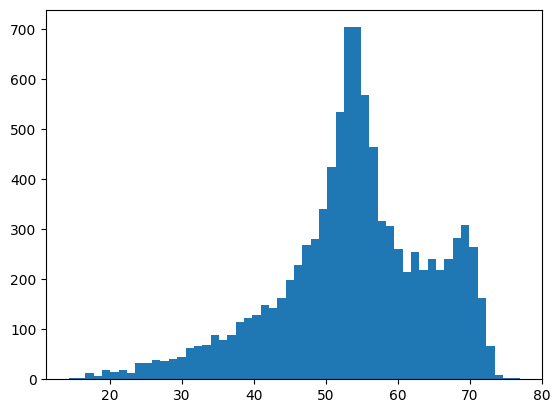

In [74]:
plt.hist(bdf.unfixed_calculated_r_2d_4_rsigms_4_tsigms, bins='auto')
plt.show()

ValueError: supplied range of [-inf, -1.869232217983901e+76] is not finite

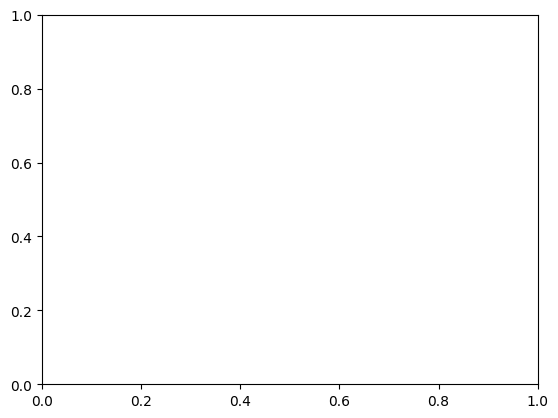

In [75]:
plt.hist(bdf.beta - bdf.beta_from_calc_r_4_rsigms_4_tsigms, bins='auto')
plt.show()

In [ ]:
def rms90(arr):
    # Calculate the mean and standard deviation of the array
    arr = arr.dropna()
    # arr_mean = np.mean(arr)
    # arr_std = np.std(arr)

    # Define the upper and lower limits for the 90% range
    lower_limit = np.percentile(arr, 5)
    upper_limit = np.percentile(arr, 95)
    # print(lower_limit, upper_limit)
    # print(arr)
    # Select the values within the 90% range
    arr_filtered = arr[(arr >= lower_limit) & (arr <= upper_limit)]
    # print(arr_filtered)
    assert arr_filtered.shape
    # Calculate the root mean square of the filtered values
    rms = np.std(arr_filtered)

    return rms

In [ ]:
def betaGroupsRMS90(bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, n = 5):
  beta_sigms = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)
  beta_epss = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)
  beta_sigms_sigms = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)

  for group in range(1, n + 1):
    data = bdf[bdf['beta_group'] == group]
    for i in range(np.ptp(avg_sigmas)):
      for j in range(np.ptp(avg_t_sigmas)):
        population_fourth_moment = np.mean(bdf[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'] ** 4)
        sample_fourth_moment = np.mean(data[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'] ** 4)
        # print(np.std(data[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms']))
        beta_sigms[i, j, group - 1] = rms90(data[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'])
        # assert not np.isnan(beta_sigms[i, j, group - 1])
        beta_epss[i, j, group - 1] = rms90(data[f'eps_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'])
        beta_sigms_sigms[i, j, group - 1] = np.sqrt(2 * np.abs(sample_fourth_moment - population_fourth_moment) / (data.shape[0]))

  return beta_sigms, beta_epss, beta_sigms_sigms

In [ ]:
def plot_final_graph(beta_sigms, beta_sigms_yerr, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, to_save=True, deg_lim=False, num_of_groups=10, iteration=0):
  # labels = ['0', '1e3', '1e4', '1e5', '1e6']
  labels = ['0']
  labels = ['DCR = ' + i + ' $Hz/mm^2$' for i in labels]
  colors = ['c', 'y', 'g', 'r', 'm']
  weight = 'weighed' if weighed else 'unweighed'
  y = np.arange(1, num_of_groups + 1)
  x = (y * (max(edf['beta']) - min(edf['beta'])) - max(edf['beta']) + (num_of_groups + 1) * min(edf['beta'])) / num_of_groups

  fig, axs = plt.subplots(np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), figsize=(10 * np.ptp(avg_t_sigmas), 10 * np.ptp(avg_sigmas)))
  title = f'Method: N(r) / r; {weight} Avg\nR Width = {r_width}mm, T Width = {t_width}ns\nR step factor = {r_factor}, T step factor = {t_factor}'
  if deg_lim:
    title += '\n' + r'$\theta_p < 10\deg$'
  # fig.suptitle(title)

  if np.ptp(avg_sigmas) > 1:
    for i in range(np.ptp(avg_sigmas)):
      for j in range(np.ptp(avg_t_sigmas)):
        for k in range(beta_sigms.shape[0]):
          axs[i, j].plot(x, beta_sigms[k, i, j], label=labels[k], c=colors[k])
          axs[i, j].errorbar(x, beta_sigms[k, i, j], xerr=[np.diff(x)[0]/4 for _ in x], linestyle='', c=colors[k])
          axs[i, j].errorbar(x, beta_sigms[k, i, j], yerr=beta_sigms_yerr[k, i, j], linestyle='', c=colors[k])
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlabel('Beta Group')
        axs[i, j].set_ylabel(r'RMS90($\Delta\beta$)')
        if deg_lim:
          axs[i, j].set_ylim((0, 0.004))
        axs[i, j].set_title(f'Velocity resoultion for\nr window width = {avg_sigmas[0] + i}$\sigma$\nt window width = {avg_t_sigmas[0] + j}$\sigma$')
        axs[i, j].grid()
  elif np.ptp(avg_t_sigmas) > 1:
    for j in range(np.ptp(avg_t_sigmas)):
      for k in range(beta_sigms.shape[0]):
        axs[j].plot(x, beta_sigms[k, 0, j], label=labels[k], c=colors[k])
        axs[j].errorbar(x, beta_sigms[k, 0, j], xerr=[np.diff(x)[0]/4 for _ in x], linestyle='', c=colors[k])
        axs[j].errorbar(x, beta_sigms[k, 0, j], yerr=beta_sigms_yerr[k, 0, j], linestyle='', c=colors[k])
      axs[j].legend(loc='upper right')
      axs[j].set_xlabel('Beta Group')
      axs[j].set_ylabel(r'RMS90($\Delta\beta)$')
      if deg_lim:
        axs[j].set_ylim((0, 0.004))
      axs[j].set_title(f'Velocity resoultion for\nr window width = {avg_sigmas[0]}$\sigma$\nt window width = {avg_t_sigmas[0] + j}$\sigma$')
      axs[j].grid()
  else:
    for k in range(beta_sigms.shape[0]):
      axs.plot(x, beta_sigms[k, 0, 0], label=labels[k], c=colors[k])
      axs.errorbar(x, beta_sigms[k, 0, 0], xerr=[np.diff(x)[0]/4 for _ in x], linestyle='', c=colors[k])
      axs.errorbar(x, beta_sigms[k, 0, 0], yerr=beta_sigms_yerr[k, 0, 0], linestyle='', c=colors[k])
    axs.legend(loc='upper right')
    axs.set_xlabel('Beta Group')
    axs.set_ylabel(r'RMS90($\Delta\beta$)')
    if deg_lim:
      # axs.set_ylim((0, 0.002))
        # revert back
      axs.set_ylim((0, 0.004))
        
        
        
    axs.set_title(f'Velocity resoultion for\nr window width = {avg_sigmas[0]}$\sigma$\nt window width = {avg_t_sigmas[0]}$\sigma$')
    axs.grid()

  if to_save:
    filename = f'{weight}_avg_rw={r_width}_tw={t_width}_rs={r_factor}_ts={t_factor}_rsigms={avg_sigmas[0]}-{avg_sigmas[-1]-1}_tsigms={avg_t_sigmas[0]}-{avg_t_sigmas[-1]-1}'
    if deg_lim:
      filename += '_10deg'
    filename += f'_{iteration}'
    filename += '.png'
    fig.savefig(os.path.join('results_barrel', f'{filename}'))
    plt.close(fig)
  else:
    plt.show()

In [ ]:
bg = betaGroupsRMS90(bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, n=num_of_groups)
beta_sigms.append(bg[0])
beta_sigms_yerr.append(bg[2])

In [ ]:
beta_sigms = np.array(beta_sigms)
beta_sigms_yerr = np.array(beta_sigms_yerr)

In [ ]:
plot_final_graph(beta_sigms, beta_sigms_yerr, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, deg_lim=False, num_of_groups=num_of_groups, iteration=0)


In [ ]:
edf_d = edf[edf.theta_p <= 10. * np.pi / 180]
edf_d = edf_d[edf_d.signal_counts >= 5]
bdf_d = bdf[bdf.theta_p <= 10. * np.pi / 180]
bdf_d = bdf_d[bdf_d.signal_counts >= 5]

In [ ]:
bg_deglim = betaGroupsRMS90(bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, n=num_of_groups)
beta_sigms_deglim.append(bg_deglim[0])
beta_sigms_yerr_deglim.append(bg_deglim[2])

In [ ]:
beta_sigms_deglim = np.array(beta_sigms_deglim)
beta_sigms_yerr_deglim = np.array(beta_sigms_yerr_deglim)

In [ ]:
plot_final_graph(beta_sigms_deglim, beta_sigms_yerr_deglim, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, deg_lim=True, num_of_groups=num_of_groups, iteration=0)

In [ ]:
bdf

In [ ]:
ы

In [ ]:
plt.hist(bdf.beta, bins='auto')
plt.xlabel('beta')
plt.show()

In [ ]:
plt.subplot()
plt.hist(bdf.cos_theta_p, bins='auto')
plt.xlabel('cos_theta_p')
plt.show()
plt.subplot()
plt.hist(bdf.theta_p, bins='auto')
plt.xlabel('theta_p')
plt.show()

primary particle - last with wv = 0

In [ ]:
# coordinates[:,3]
lambdas = np.concatenate(coordinates[:,3])

In [ ]:
lambdas.shape

In [ ]:
lambdas.shape[0] / coordinates.shape[0]

In [ ]:
plt.hist(lambdas, bins=PDE_wvs)
plt.xlabel('Wavelength, nm')
plt.title(f'Energy: 1500 MeV\nMean: {round(lambdas.mean(), 1)} nm' + '\n' + f'Std: {round(lambdas.std(), 1)} nm')
plt.ylabel('Hits')
# plt.xlim((200, 900))
plt.show()

In [ ]:
# delta_r = np.sqrt(x ** 2 + y ** 2 - 1000 ** 2)
plt.scatter(coordinates[0][0], coordinates[0][2], c='red', s=3)
# plt.plot(1000 * np.cos(np.linspace(0, 2*np.pi,1000)), 1000 * np.sin(np.linspace(0, 2*np.pi,1000)))
# plt.xlim((-160, 50))
# plt.ylim((-1100, -650))
plt.xlabel('X, mm')
plt.ylabel('Z, mm')
# plt.title('p = 1500 MeV' + f'\n{coordinates[0][0].shape[0]} Hits')
plt.show()

In [ ]:
print(coordinates[0][0].shape)

In [ ]:
plt.scatter(PDE_wvs, PDEs)
plt.show()

In [ ]:
events_len = []
for i in range(coordinates.shape[0]):
    events_len.append(len(coordinates[i][0]))
events_len = np.array(events_len)
plt.hist(events_len, bins='auto')
plt.xlabel('Hits in event')
plt.title(f'Energy: 1500 MeV\nMean: {round(events_len.mean(), 1)}' + '\n' + f'Std: {round(events_len.std(), 1)}')
plt.ylabel('Events')
plt.show()

# End of main

In [ ]:
coordinates[0]

In [ ]:
lambdas = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array()) * 1e-9

In [ ]:
lambdas = np.concatenate(lambdas)

In [ ]:
lambdas = lambdas[lambdas > 150]

In [ ]:
mask = (lambdas >= 380) & (lambdas <= 780)

In [ ]:
lambdas[mask].shape[0] / lambdas.shape[0]

In [ ]:
lambdas.shape[0]

In [ ]:
plt.hist(lambdas, bins='auto')
plt.xlabel('Wavelength, nm')
plt.title(f'Energy: 1500 MeV\nMean: {round(lambdas.mean(), 1)} nm' + '\n' + f'Std: {round(lambdas.std(), 1)} nm')
plt.ylabel('Hits')
plt.show()

In [ ]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    # arr = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9
    # mask = (arr >= 350) & (arr <= 800)
    # cut_shapes[num] = arr[mask].shape[0]
    cut_shapes[num] = np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num].shape[0]

In [ ]:
plt.hist(cut_shapes, bins='auto')
plt.title(f'Energy: 1500 MeV\nMean: {round(cut_shapes.mean(), 1)}' + '\n' + f'Std: {round(cut_shapes.std(), 1)}')
plt.xlabel('Photons in event')
plt.show()

In [ ]:
num = 5
plt.hist(1239.841 / (1 * (np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num][np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] < 1e-8] * 1e9)), bins='auto')
plt.show()

In [ ]:
plt.hist([np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[i].shape[0] for i in range(1000)], bins='doane')
plt.show()

In [ ]:
minn = 1
for i in range(1000):
    try:
        tmp  = min(np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[i])
    except ValueError:
        pass
    minn = min(minn, tmp)
print(minn)

In [ ]:
pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
t1 = []
t2 = []
for inedx, row in pdes_tmp.iterrows():
    t1.append(float(row['A'].split(';')[0].replace(',', '.')))
    t2.append(float(row['A'].split(';')[1].replace(',', '.')))

In [ ]:
t1 = np.array(t1)
t2 = np.array(t2)

In [ ]:
plt.scatter(t1, t2)
plt.show()

In [ ]:
t1.shape

In [ ]:
a1, a2_ = np.histogram(lambdas, bins=128)

In [ ]:
PDE_wvs = (PDE_wvs[1:] + PDE_wvs[:-1]) / 2

In [ ]:
PDE_wvs.shape

In [ ]:
plt.step(PDE_wvs, a1, where='post')
plt.show()

In [ ]:
a1.shape

In [ ]:
a1.sum()

In [ ]:
# conv_x = np.arange(min(t1.min(), a2.min()), max(t1.max(), a2.max()) + 1)


In [ ]:
PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
# dist1_interpolated = dist1_interpolated / dist1_interpolated.sum()
# dist2_interpolated = np.interp(conv_x, a2, a1 / a1.sum(), left=0, right=0)

# Perform convolution
convolution_result = np.convolve(PDEs, a1, mode='same')


In [ ]:
plt.scatter(PDE_wvs, PDEs)
plt.show()

In [ ]:
PDEs.sum()

In [ ]:
dist2_interpolated.shape[0]

In [ ]:
convolution_result.sum()

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax2.step(PDE_wvs, PDEs, label='SiPM Sensitivity')
ax1.step(PDE_wvs, a1, label='Original Distribution', c='g')
ax1.step(PDE_wvs, a1 * PDEs, label='Convolution', c='orange')

ax1.set_title('Convolution of Distributions')
ax1.set_xlabel('Wavelength, nm')
ax1.set_ylabel('Hits')
plt.ylabel('PDE, %')
# ax1.legend()
ax2.legend()
plt.show()

In [ ]:
response = a1 * PDEs

In [ ]:
response.sum() / a1.sum()

In [ ]:
response.sum()

In [ ]:
plt.step(PDE_wvs, a1 * PDEs, label='conv')
plt.title('Свёрнутый спектр')
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')
plt.show()

In [ ]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9
    arr = arr[arr > 150]
    arr_bins = np.histogram(arr, bins=a1.shape[0])
    cut_shapes[num] = (arr_bins[0] * PDEs).sum()


In [ ]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9 # for 500
    arr = arr[arr > 150]
    arr_bins = np.histogram(arr, bins=a1.shape[0])
    cut_shapes[num] = (arr_bins[0] * PDEs).sum()


In [ ]:
plt.hist(cut_shapes, bins='auto')
plt.title(f'Energy: 500\nMean: {round(cut_shapes.mean(), 1)}' + '\n' + f'Std: {round(cut_shapes.std(), 1)}')
plt.show()

In [ ]:
arr_bins = np.histogram(arr, bins=a1.shape[0])

In [ ]:
(arr_bins[0] * PDEs).sum() / arr_bins[0].sum()

In [ ]:
plt.hist(arr, bins=a1.shape[0])
plt.step(PDE_wvs, arr_bins[0])
plt.step(PDE_wvs, arr_bins[0] * PDEs)
plt.show()

In [ ]:
mins = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9 # for 500
    try:
        mins[num] = min(arr)
    except ValueError:
        pass

In [ ]:
plt.hist(mins)
plt.show()

In [ ]:
energies = np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())

In [ ]:
energies = np.concatenate(energies)

In [ ]:
energies.shape

In [ ]:
energies = energies[energies < 1e-7]

In [ ]:
energies.shape

In [ ]:
energies = energies * 1e9

In [ ]:
energies = energies[energies < 7.5]

In [ ]:
energies.shape

In [ ]:
plt.hist(energies[energies < 7.5], bins='auto')
plt.show()

In [ ]:
plt.hist(1239.8 / energies,bins='auto')
plt.show()

In [ ]:
wavelengths_prototype = np.concatenate(file_prototype['raw_data;2']['event']['m_hits']['m_hits.m_photon_wl'].array())

In [ ]:
wavelengths_prototype_1500 = file_prototype['raw_data;2']['event']['m_hits']['m_hits.m_photon_wl'].array()


In [ ]:
wavelengths_prototype_1500.shape

In [ ]:
wv_res = []
wv_res_len = 0
wv_res_sizes = []

In [ ]:
for i in range(wavelengths_prototype_1500.shape[0]):
    if betas_prototype[i] >= 0.99569:
        wv_res.extend(wavelengths_prototype_1500[i])
        wv_res_len += 1
        wv_res_sizes.append(wavelengths_prototype_1500[i].shape[0])

In [ ]:
wv_res = np.array(wv_res)
wv_res_sizes = np.array(wv_res_sizes)

In [ ]:
print(wv_res.shape[0], wv_res_len, wv_res.shape[0]/wv_res_len)

In [ ]:
plt.hist(wv_res, bins='doane')
plt.show()

In [ ]:
plt.hist(wv_res_sizes, bins='auto')
plt.xlabel('Hits in event')
plt.title(f'Mean: {round(wv_res_sizes.mean(), 1)}' + '\n' + f'Std: {round(wv_res_sizes.std(), 1)}')
plt.ylabel('Events')
plt.show()

In [ ]:
mask = betas_prototype >= 0.99569

In [ ]:
mask.sum()

In [ ]:
wv_res.shape[0] / mask.sum()

In [ ]:
betas_prototype = file_prototype['raw_data;2']['event']['m_beta_primary'].array()

In [ ]:
wavelengths_prototype_1500 = wavelengths_prototype_1500[mask]


In [ ]:
betas_prototype[0]

In [ ]:
betas_prototype.shape

In [ ]:
wavelengths_prototype.shape

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wavelengths_prototype, bins='auto', density=False)
plt.subplot(122)
plt.hist(wavelengths_prototype, bins='auto', density=False)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wv_res, bins='auto', density=False)
plt.subplot(122)
plt.hist(wv_res, bins='auto', density=False)
plt.show()

In [ ]:
xml_energies, xml_r = [], []
xml_data = []
with open(os.path.join(datadir, 'rindex.txt')) as f:
    for line in f:
        xml_data.append(np.array(line.split('*eV '), dtype='float64'))
        # print(np.array(line.split('*eV '), dtype='float64'))
        # break
xml_data = np.array(xml_data)

In [ ]:
xml_data.shape

In [ ]:
# plt.subplots(1, 2)
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(xml_data[:,0], xml_data[:,1])
plt.xlabel('Energy, eV')
plt.ylabel('Refractive index n')
plt.subplot(122)
plt.plot(1239.8 / xml_data[:,0], xml_data[:,1])
plt.xlabel('Wavelength, nm')
plt.ylabel('Refractive index n')
plt.show()

In [ ]:
binned_wavelengths_prototype = np.histogram(wavelengths_prototype, 1239.8 / xml_data[:,0])
binned_wavelengths_full = np.histogram(lambdas, 1239.8 / xml_data[:,0])

binned_energies_prototype = np.histogram(1239.841 / wavelengths_prototype, xml_data[:,0][::-1])

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wavelengths_prototype, bins= new_bins, density=False)
plt.subplot(122)
plt.hist(wavelengths_prototype, bins= new_wv_bins, density=False)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=False)
plt.step(binned_wavelengths_prototype[1][1:], binned_wavelengths_prototype[0])

plt.subplot(122)
plt.hist(lambdas, bins=1239.8 / xml_data[:,0], density=False)
plt.step(binned_wavelengths_full[1][1:], binned_wavelengths_full[0])
plt.show()

In [ ]:
xml_data[:,1]

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(lambdas, bins=1239.8 / xml_data[:,0], density=True, alpha=1)

# plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=True, alpha=0.5)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')

plt.subplot(122)
plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=True)
plt.step(binned_wavelengths_prototype[1][1:], binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum() / 10)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')

plt.show()

In [ ]:
(binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum() / 10).sum()

In [ ]:
(binned_wavelengths_full[0] / binned_wavelengths_full[0].sum()).sum()

In [ ]:
reg = LinearRegression().fit((binned_wavelengths_full[0] / binned_wavelengths_full[0].sum()).reshape(-1, 1), xml_data[:,1][1:])

In [ ]:
print(reg.coef_, reg.intercept_)

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(xml_data[:,0], xml_data[:,1])
plt.plot(xml_data[:,0][1:], (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_ )
plt.xlabel('Energy, eV')
plt.ylabel('Refractive index n')
plt.subplot(122)
plt.plot(1239.8 / xml_data[:,0], xml_data[:,1])
plt.plot(binned_wavelengths_prototype[1][1:], (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_ )
plt.xlabel('Wavelength, nm')
plt.ylabel('Refractive index n')
plt.show()

In [ ]:
out = (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_

In [ ]:
out

In [ ]:
with open(os.path.join(datadir, 'rindex_out.txt'), 'w') as f:
    f.write('6.19921*eV 1.04929\n')
    for en, n in zip(xml_data[:,0][1:], out):
        f.write('    {:.5f}*eV {:.5f}\n'.format(round(en, 5), round(n, 5)))


In [ ]:
new_bins = np.linspace(1.37760, 5.90401, 101)
new_wv_bins = np.linspace(200, 900, 101)

In [ ]:
wavelengths_prototype.shape[0] / betas_prototype.shape[0]

In [ ]:
wv_res.shape[0] / mask.sum()

In [ ]:
test_num = 35
filepath_new = os.path.join(datadir, f'fullsim_optical_1000_pi_1500_spectre_test_{test_num}.root')
file_new = uproot.open(filepath_new)
energies_new = np.array(file_new['events;1']['FarichBarrelG4Hits.energy'].array()) * 1e9
energies_new = np.concatenate(energies_new)
energies_new = energies_new[energies_new < 7.5]
lambdas_new = 1239.841 / energies_new
# lambdas_new = np.concatenate(lambdas_new)
# lambdas_new = lambdas_new[lambdas_new > 150]
print(lambdas_new.shape)
print(lambdas_new.shape[0] / np.array(file_new['events;1']['allGenParticles.core.pdgId'].array()).shape[0])

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(energies_new, bins=new_bins)
plt.xlabel('Energy, eV')
plt.ylabel('Hits')
plt.subplot(122)
plt.hist(lambdas_new, bins=new_wv_bins)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')
plt.show()

In [ ]:
plot_cyl(file)